In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta#Work with dates and time ranges
import warnings
warnings.filterwarnings('ignore')

# Statistical libraries
from statsmodels.tsa.stattools import adfuller#Required before ARIMA modeling
from statsmodels.tsa.seasonal import seasonal_decompose#time series decomposition
from statsmodels.tsa.arima.model import ARIMA#Used for baseline stock price prediction

# Machine Learning libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")#husl palette ensures distinct,visually balanced colors


Data Collection

In [ ]:
#Fetch Tesla Stock Data
print("\n Fetching Tesla (TSLA) historical data from Yahoo Finance...")
ticker = yf.Ticker('TSLA')
df_tesla = ticker.history(period='max')


 Fetching Tesla (TSLA) historical data from Yahoo Finance...


In [ ]:
# Reset index
# df_tesla = df_tesla.reset_index()
df_testla = df_tesla['2023-11-03':'2025-11-03']
# df_tesla = df_tesla.set_index('Date', drop=True)
# df_filterd=df_tesla['2023-11-03':'2025-11-03']
print(f"\n Data fetched successfully!")
print(f" Total records: {len(df_tesla)}")
print(f" Date range: {df_tesla.index.min().strftime('%Y-%m-%d')} to {df_tesla.index.max().strftime('%Y-%m-%d')}")


 Data fetched successfully!
 Total records: 3909
 Date range: 2010-06-29 to 2026-01-12


In [ ]:
# Display sample data
print("\nFirst 5 rows:")
display(df_tesla.head())


First 5 rows:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [ ]:
print("\nLast 5 rows:")
display(df_tesla.tail())


Last 5 rows:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2026-01-06 00:00:00-05:00,446.380005,448.250000,428.779999,432.959991,89093800,0.0,0.0
2026-01-07 00:00:00-05:00,435.899994,438.369995,431.290009,431.410004,59828800,0.0,0.0
2026-01-08 00:00:00-05:00,427.890015,436.890015,424.369995,435.799988,57041100,0.0,0.0
2026-01-09 00:00:00-05:00,435.950012,449.049988,430.390015,445.010010,67331500,0.0,0.0
2026-01-12 00:00:00-05:00,441.230011,454.299988,438.000000,448.959991,61451900,0.0,0.0


In [ ]:
print("\nStatistical Summary:")
display(df_tesla.describe())


Statistical Summary:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3909.000000,3909.000000,3909.000000,3909.000000,3.909000e+03,3909.0,3909.000000
mean,99.806098,101.989359,97.476937,99.783566,9.669453e+07,0.0,0.002047
std,126.112207,128.841243,123.127379,126.029135,7.564768e+07,0.0,0.093252
min,1.076000,1.108667,0.998667,1.053333,1.777500e+06,0.0,0.000000
25%,12.743333,12.966667,12.550000,12.812000,5.145450e+07,0.0,0.000000
50%,19.966667,20.320667,19.572001,19.950666,8.328360e+07,0.0,0.000000
75%,208.649994,214.250000,203.399994,207.966660,1.209630e+08,0.0,0.000000
max,489.880005,498.829987,485.329987,489.880005,9.140820e+08,0.0,5.000000


In [ ]:
#  Data Preprocessing and Feature Engineering

In [ ]:
# Remove missing values
df_tesla = df_tesla.dropna()

In [ ]:
# Create technical indicators
df_tesla['Daily_Return'] = df_tesla['Close'].pct_change()#day-to-day percentage change(price)
df_tesla['Volatility'] = df_tesla['Daily_Return'].rolling(window=20).std()#Computes standard deviation of returns over last 20 days
df_tesla['MA_7'] = df_tesla['Close'].rolling(window=7).mean()#Short-term trend indicator
df_tesla['MA_30'] = df_tesla['Close'].rolling(window=30).mean()#Medium-term trend smoothing
df_tesla['MA_90'] = df_tesla['Close'].rolling(window=90).mean()#Long-term price trend
df_tesla['Price_Change'] = df_tesla['Close'] - df_tesla['Open']#Measures price movement within the same trading day
df_tesla['High_Low_Spread'] = df_tesla['High'] - df_tesla['Low']#Calculates intraday price range

In [ ]:
# Create technical indicators (re-adding to ensure they are present after initial dropna)
df_tesla['Daily_Return'] = df_tesla['Close'].pct_change()
df_tesla['Volatility'] = df_tesla['Daily_Return'].rolling(window=20).std()
df_tesla['MA_7'] = df_tesla['Close'].rolling(window=7).mean()
df_tesla['MA_30'] = df_tesla['Close'].rolling(window=30).mean()
df_tesla['MA_90'] = df_tesla['Close'].rolling(window=90).mean()
df_tesla['Price_Change'] = df_tesla['Close'] - df_tesla['Open']
df_tesla['High_Low_Spread'] = df_tesla['High'] - df_tesla['Low']

# Remove NaN values (now including those created by rolling functions/shifts)
df_tesla = df_tesla.dropna()

print(f"Preprocessing complete!")
print(f"Final dataset shape: {df_tesla.shape}")
print(f"Features: {list(df_tesla.columns)}")

Preprocessing complete!
Final dataset shape: (3820, 14)
Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Daily_Return', 'Volatility', 'MA_7', 'MA_30', 'MA_90', 'Price_Change', 'High_Low_Spread']



 Creating Exploratory Data Analysis visualizations...


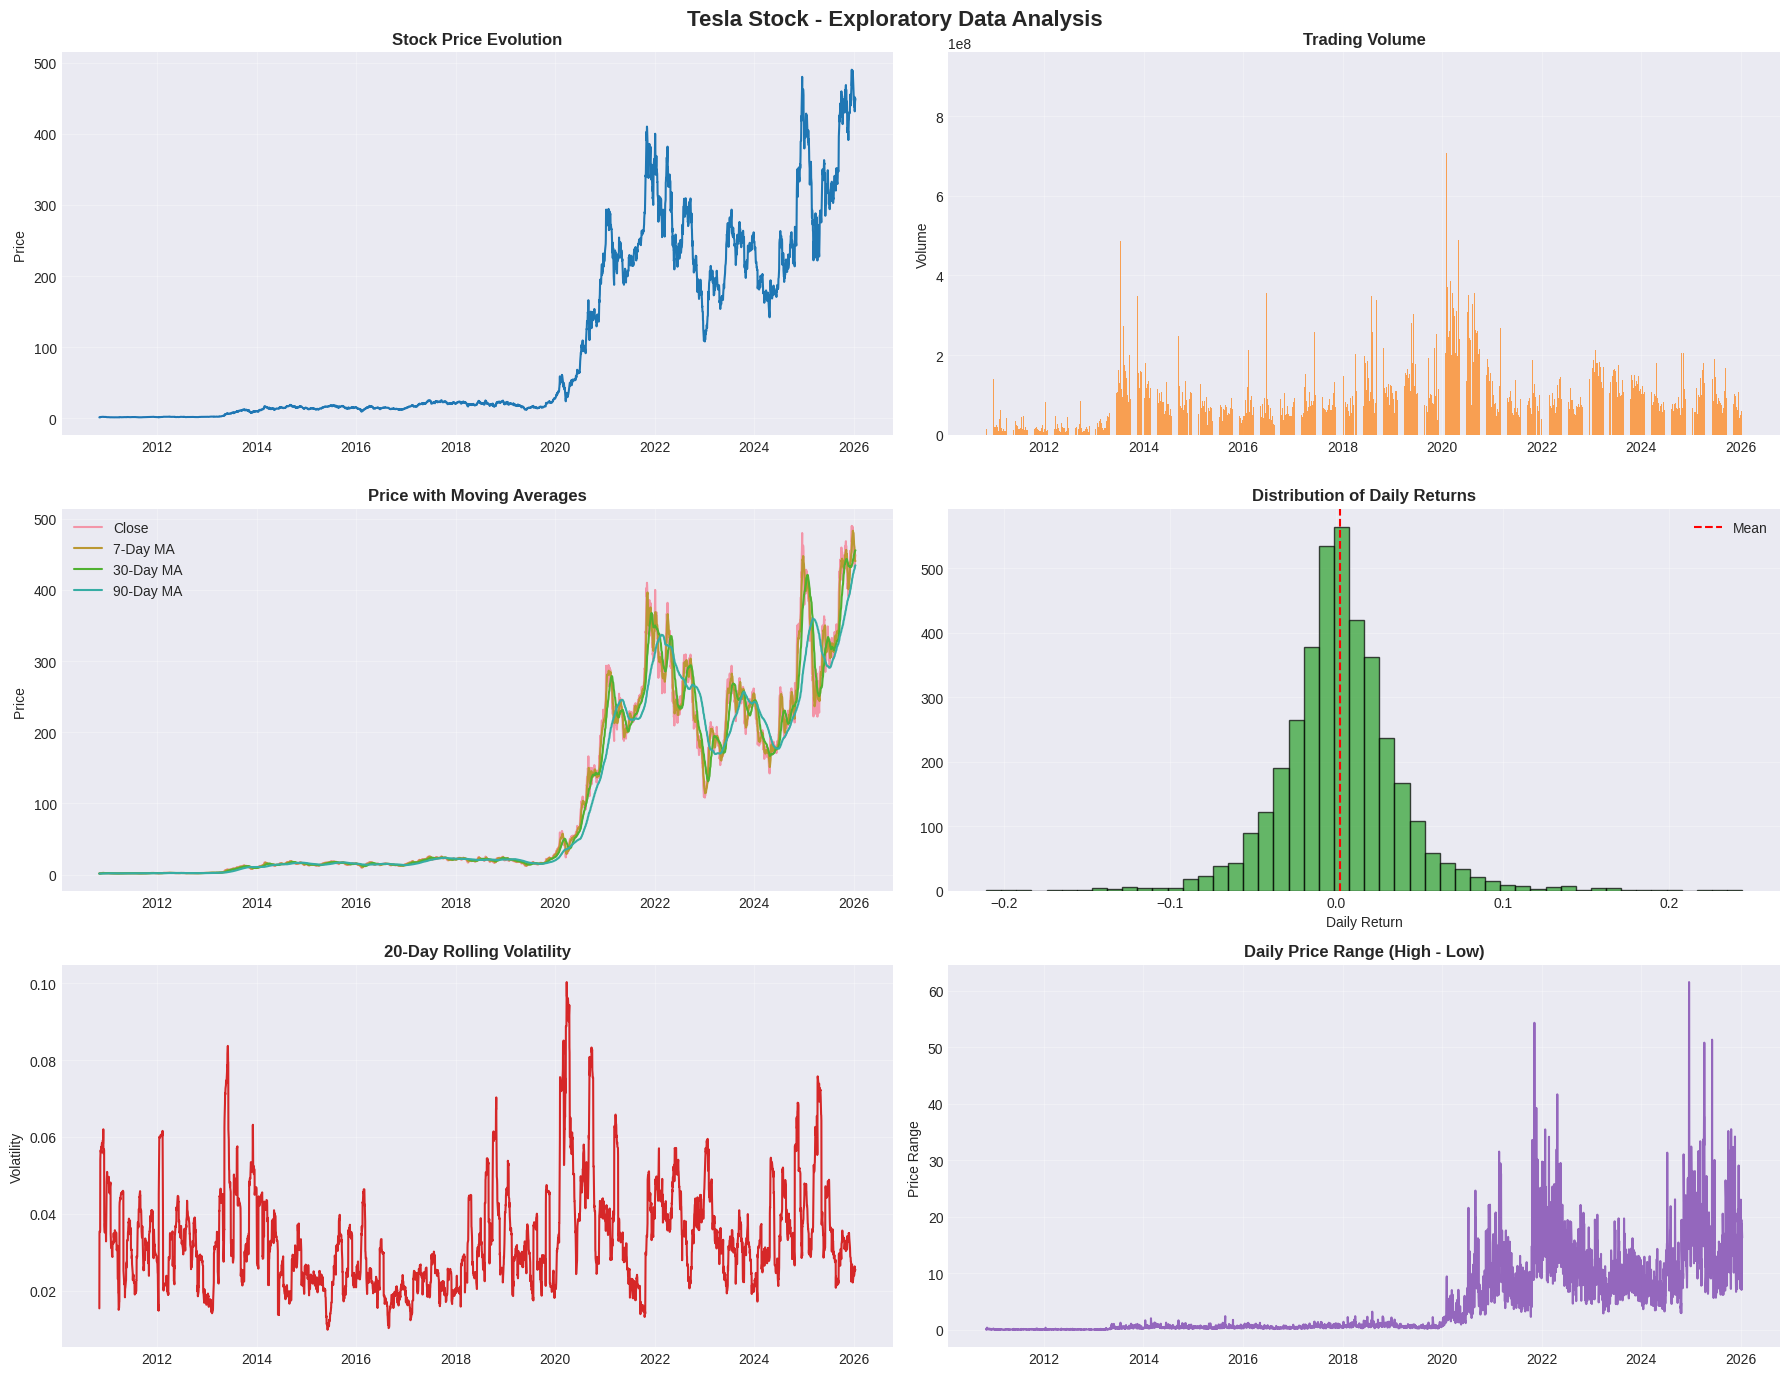

In [ ]:
print("\n Creating Exploratory Data Analysis visualizations...")

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
fig.suptitle('Tesla Stock - Exploratory Data Analysis', fontsize=16, fontweight='bold')
df_testla = df_tesla['2023-11-03':'2025-11-03']

# 1. Price Evolution-shows Tesla’s growth and trends
axes[0, 0].plot(df_tesla.index, df_tesla['Close'], linewidth=1.5, color='#1f77b4')
axes[0, 0].set_title('Stock Price Evolution', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Price ')
axes[0, 0].grid(True, alpha=0.3)

# 2. Trading Volume-indicates investor activity
axes[0, 1].bar(df_tesla.index, df_tesla['Volume'], color='#ff7f0e', alpha=0.7, width=1)
axes[0, 1].set_title('Trading Volume', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True, alpha=0.3)

# 3. Moving Averages-smooths price fluctuations
axes[1, 0].plot(df_tesla.index, df_tesla['Close'], label='Close', linewidth=1.5, alpha=0.7)
axes[1, 0].plot(df_tesla.index, df_tesla['MA_7'], label='7-Day MA', linewidth=1.5)
axes[1, 0].plot(df_tesla.index, df_tesla['MA_30'], label='30-Day MA', linewidth=1.5)
axes[1, 0].plot(df_tesla.index, df_tesla['MA_90'], label='90-Day MA', linewidth=1.5)
axes[1, 0].set_title('Price with Moving Averages', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Price ')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Daily Returns-shows risk and volatility
axes[1, 1].hist(df_tesla['Daily_Return'].dropna(), bins=50, color='#2ca02c', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribution of Daily Returns', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Daily Return')
axes[1, 1].axvline(df_tesla['Daily_Return'].mean(), color='red', linestyle='--', label='Mean')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5. Volatility-measures market uncertainty
axes[2, 0].plot(df_tesla.index, df_tesla['Volatility'], color='#d62728', linewidth=1.5)
axes[2, 0].set_title('20-Day Rolling Volatility', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Volatility')
axes[2, 0].grid(True, alpha=0.3)

# 6. Price Range-shows daily price movement range
axes[2, 1].plot(df_tesla.index, df_tesla['High_Low_Spread'], color='#9467bd', linewidth=1.5)
axes[2, 1].set_title('Daily Price Range (High - Low)', fontsize=12, fontweight='bold')
axes[2, 1].set_ylabel('Price Range ')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

We predict stationarity to ensure the forecasting model’s assumptions are valid and predictions are trustworthy.

In [ ]:
#  Stationarity Test
print("\n Testing Time Series Stationarity...")
print("   (Augmented Dickey-Fuller Test)")

result = adfuller(df_tesla['Close'].dropna())

print(f"\n Test Results:")
print(f"ADF Statistic: {result[0]:.6f}")#test score
print(f"p-value: {result[1]:.6f}")#probability of non stationarity
print(f"\nCritical Values:")#Critical values are benchmark thresholds used to determine whether a time series is stationary by comparing them with the test statistic.
for key, value in result[4].items():
    print(f"{key}: {value:.3f}")
#ADF Statistic < Critical Value=Series is stationary
#ADF Statistic > Critical Value=Series is non-stationary
if result[1] <= 0.05:
    print("\n Series is STATIONARY - Good for modeling")
else:
    print("\n  Series is NON-STATIONARY - Differencing needed")


 Testing Time Series Stationarity...
   (Augmented Dickey-Fuller Test)

 Test Results:
ADF Statistic: -0.466128
p-value: 0.898459

Critical Values:
1%: -3.432
5%: -2.862
10%: -2.567

  Series is NON-STATIONARY - Differencing needed


We use time series decomposition to understand the structure of stock price data before building forecasting models.

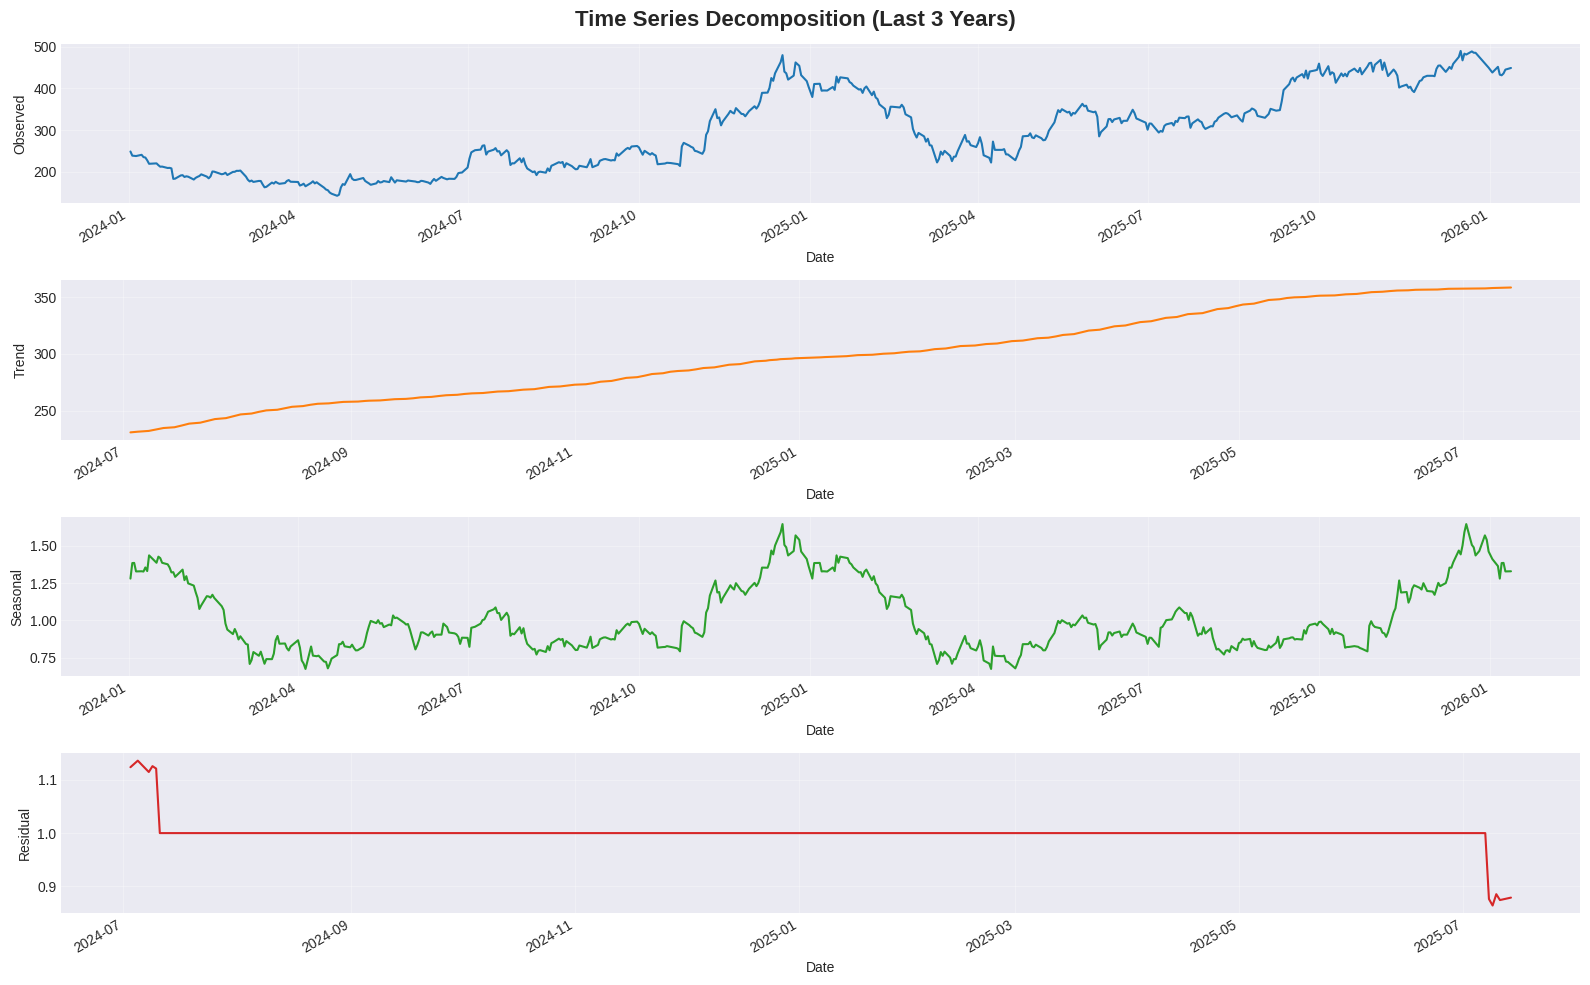

In [ ]:
# Time Series Decomposition -trend,seasonal,residual
recent_data = df_tesla['Close'].last('3Y')
decomposition = seasonal_decompose(recent_data, model='multiplicative', period=252)

fig, axes = plt.subplots(4, 1, figsize=(16, 10))
fig.suptitle('Time Series Decomposition (Last 3 Years)', fontsize=16, fontweight='bold')

decomposition.observed.plot(ax=axes[0], color='#1f77b4')
axes[0].set_ylabel('Observed')#Actual closing price
axes[0].grid(True, alpha=0.3)

decomposition.trend.plot(ax=axes[1], color='#ff7f0e')
axes[1].set_ylabel('Trend')#Long-term direction
axes[1].grid(True, alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], color='#2ca02c')
axes[2].set_ylabel('Seasonal')#Repeating yearly pattern
axes[2].grid(True, alpha=0.3)

decomposition.resid.plot(ax=axes[3], color='#d62728')
axes[3].set_ylabel('Residual')#Random noise
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

MODEL 1 - ARIMA

In [ ]:
#i have used arima model as baseline forecasting
# Split data
train_size = int(len(df_tesla) * 0.8)
train_data = df_tesla['Close'][:train_size]
test_data = df_tesla['Close'][train_size:]
print(f"\n Training size: {len(train_data)} | Test size: {len(test_data)}")


 Training size: 3056 | Test size: 764


In [ ]:
# Build and train
print("\n Building ARIMA model...")
model_arima = ARIMA(train_data, order=(5, 1, 2))
model_arima_fit = model_arima.fit()


 Building ARIMA model...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Predictions
predictions_arima = model_arima_fit.forecast(steps=len(test_data))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# Metrics
rmse_arima = np.sqrt(mean_squared_error(test_data, predictions_arima))#actual price=test_data
mae_arima = mean_absolute_error(test_data, predictions_arima)#(Actual − Predicted)²
print(f"\n ARIMA Performance:")
print(f"RMSE: {rmse_arima:.2f}")
print(f"MAE: {mae_arima:.2f}")


 ARIMA Performance:
RMSE: 169.55
MAE: 143.88


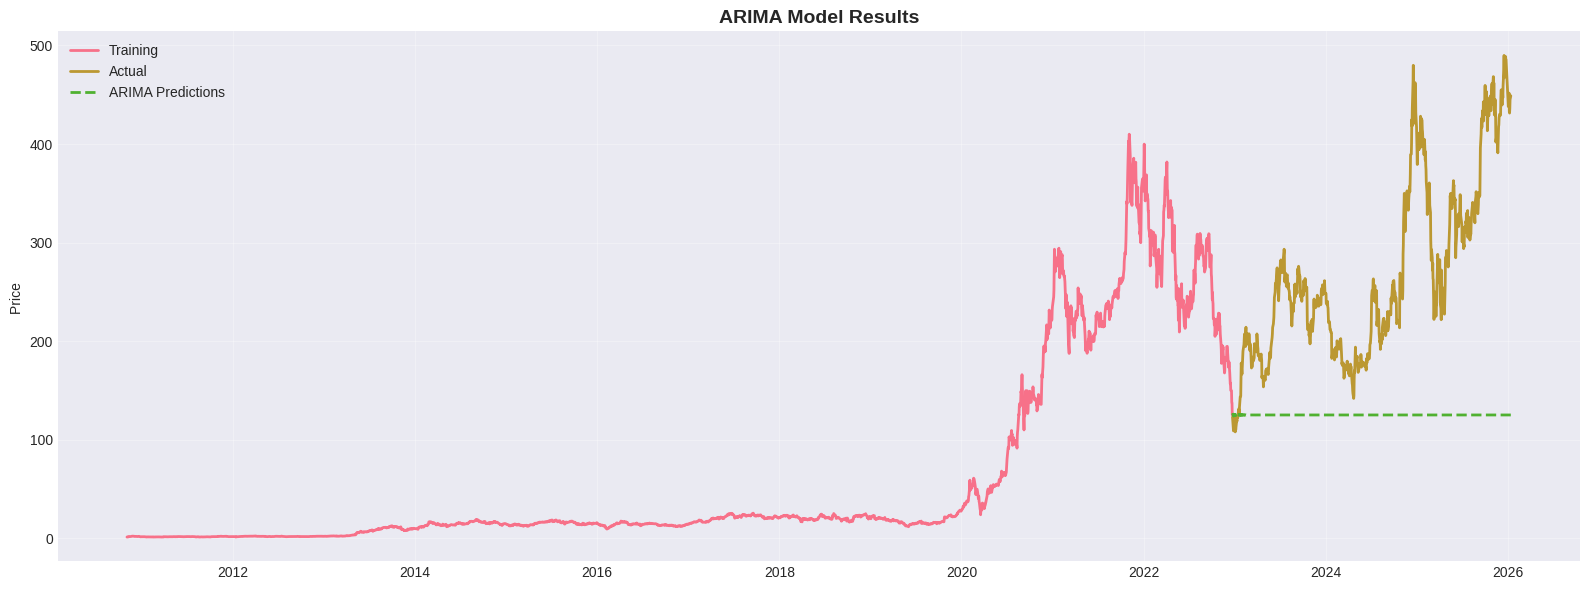

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train_data.index, train_data, label='Training', linewidth=2)
ax.plot(test_data.index, test_data, label='Actual', linewidth=2)
ax.plot(test_data.index, predictions_arima, label='ARIMA Predictions', linewidth=2, linestyle='--')
ax.set_title('ARIMA Model Results', fontsize=14, fontweight='bold')
ax.set_ylabel('Price ')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Store results
results_comparison = {'ARIMA': {'RMSE': rmse_arima, 'MAE': mae_arima}}

 MODEL 2 - PROPHET

Why Use Prophet?

Time-series forecasting

Trend + seasonality + holidays

In [ ]:
from prophet import Prophet
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)#This line hides unnecessary messages

# Prepare data
prophet_df = df_tesla.reset_index()[['Date', 'Close']].copy()
#Date → time column
#Close → target variable
prophet_df.columns = ['ds', 'y']#ds=datetime,y=value of forecast

train_size_prophet = int(len(prophet_df) * 0.8)
train_prophet = prophet_df[:train_size_prophet]
test_prophet = prophet_df[train_size_prophet:]

print(f"\n Training size: {len(train_prophet)} | Test size: {len(test_prophet)}")


 Training size: 3056 | Test size: 764


In [ ]:
# Build and train
print("\n Building Prophet model...")
model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True,
                        yearly_seasonality=True, changepoint_prior_scale=0.05)#0.05 will control trend flexibility

# Ensure the 'ds' column in train_prophet is timezone-naive before fitting the model.
train_prophet['ds'] = train_prophet['ds'].dt.tz_localize(None)

model_prophet.fit(train_prophet)


 Building Prophet model...


In [ ]:
# Predictions
future = model_prophet.make_future_dataframe(periods=len(test_prophet))
forecast = model_prophet.predict(future)
predictions_prophet = forecast.iloc[train_size_prophet:]['yhat'].values#predicted value(main forecast)

In [ ]:
# Metrics
rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], predictions_prophet))
mae_prophet = mean_absolute_error(test_prophet['y'], predictions_prophet)

print(f"\n Prophet Performance:")
print(f"RMSE: {rmse_prophet:.2f}")
print(f"MAE: {mae_prophet:.2f}")


 Prophet Performance:
RMSE: 139.72
MAE: 125.29


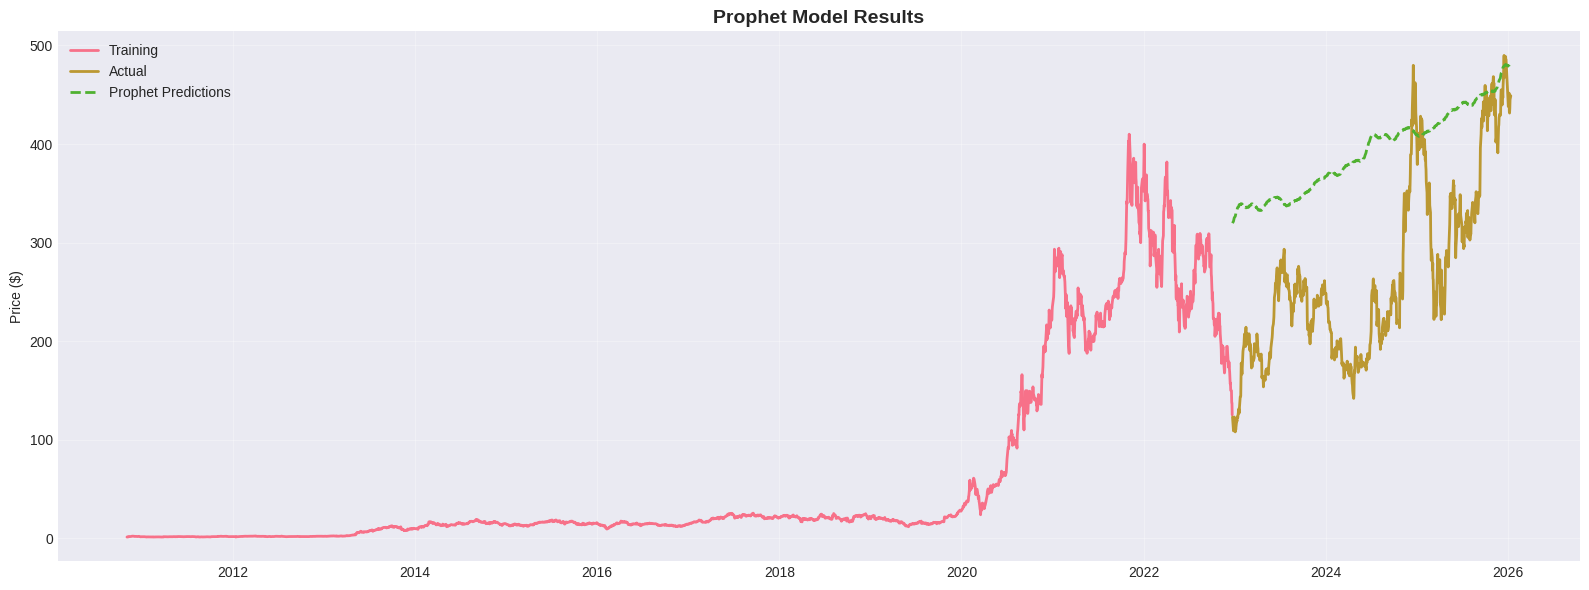


Prophet Components:


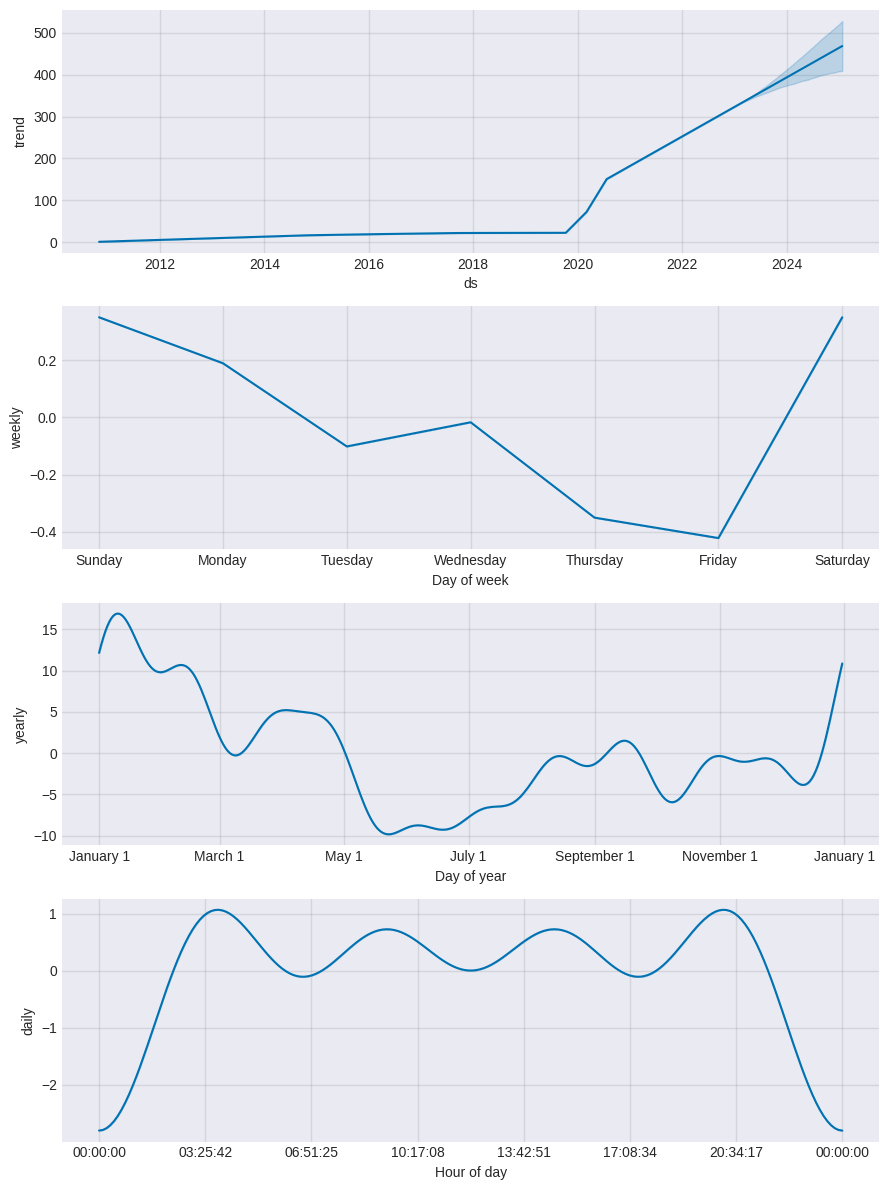

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train_prophet['ds'], train_prophet['y'], label='Training', linewidth=2)
ax.plot(test_prophet['ds'], test_prophet['y'], label='Actual', linewidth=2)
ax.plot(test_prophet['ds'], predictions_prophet, label='Prophet Predictions', linewidth=2, linestyle='--')
ax.set_title('Prophet Model Results', fontsize=14, fontweight='bold')
ax.set_ylabel('Price ($)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nProphet Components:")
fig2 = model_prophet.plot_components(forecast)
plt.show()

results_comparison['Prophet'] = {'RMSE': rmse_prophet, 'MAE': mae_prophet}


Train data  --- Prophet model trained  ---Forecast all dates
                                     --- Extract test predictions  --Compare with actual


In [ ]:
#  MODEL 3 - LSTM

Since stock prices are sequential, I used an LSTM neural network.

Scaling data using MinMaxScaler

Creating 60-day sequences

Building multi-layer LSTM with Dropout

Using EarlyStopping to prevent overfitting

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential#simplest way to build a neural network in Keras.
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Prepare data
look_back = 60  #60 timesteps
data = df_tesla['Close'].values.reshape(-1, 1)#converts pandas series to numpy array,converts to 2D
scaler = MinMaxScaler(feature_range=(0, 1))#all values to the range 0–1.
scaled_data = scaler.fit_transform(data)

In [ ]:
# Create sequences
def create_sequences(data, look_back):
    X, y = [], []
    # X=look_back
    # y=next day value
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, look_back)

In [ ]:
# Split
train_size_lstm = int(len(X) * 0.8)
X_train = X[:train_size_lstm].reshape(-1, look_back, 1)
X_test = X[train_size_lstm:].reshape(-1, look_back, 1)
y_train = y[:train_size_lstm]
y_test = y[train_size_lstm:]
print(f"\n Training shape: {X_train.shape} | Test shape: {X_test.shape}")


 Training shape: (3008, 60, 1) | Test shape: (752, 60, 1)


In [ ]:
# Build model
#This LSTM architecture learns complex time-based patterns in stock prices to predict future values accurately.
print("\n Building LSTM model...")
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')


 Building LSTM model...


In [ ]:
# Train
print("\n Training LSTM..")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#earlystopping=automatically stops training when the model stops improving.
#patience=does not improve for 10 consecutive epochs, training stops
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, #before updating weights
                         validation_split=0.1, callbacks=[early_stop], verbose=1)
#One complete pass of the entire training dataset through the model is epochs


 Training LSTM..
Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 6.1212e-04 - val_loss: 0.0039
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 6.1545e-04 - val_loss: 0.0033
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 6.0738e-04 - val_loss: 0.0038
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 4.3240e-04 - val_loss: 0.0040
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 4.3082e-04 - val_loss: 0.0032
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 4.2210e-04 - val_loss: 0.0029
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 4.1588e-04 - val_loss: 0.0026
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 4.2215e-04 - val_loss: 0.0030
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 4.1616e-04 - val_loss: 0.0024
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 3.5884e-04 - val_loss: 0.0031
Ep

In [ ]:
# Predictions
predictions_lstm = model_lstm.predict(X_test, verbose=0)#Print progress and loss during training
predictions_lstm = scaler.inverse_transform(predictions_lstm)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, predictions_lstm))
mae_lstm = mean_absolute_error(y_test_actual, predictions_lstm)

print(f"\n LSTM Performance:")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"MAE: {mae_lstm:.2f}")


 LSTM Performance:
RMSE: 16.46
MAE: 12.05


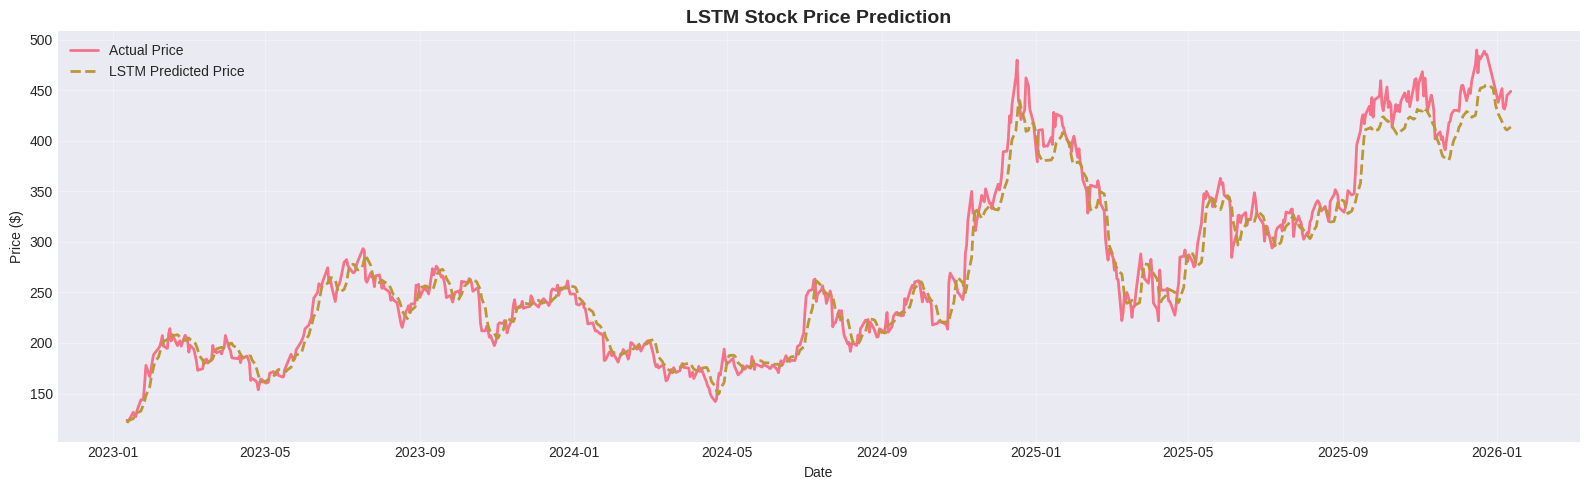

In [ ]:
# Plot ONLY LSTM Predictions
plt.figure(figsize=(16, 5))

test_dates = df_tesla.index[train_size_lstm + look_back:]

plt.plot(test_dates, y_test_actual,
         label='Actual Price', linewidth=2)

plt.plot(test_dates, predictions_lstm,
         label='LSTM Predicted Price', linewidth=2, linestyle='--')

plt.title('LSTM Stock Price Prediction', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


 MODEL 4 - XGBOOST

For machine learning models like XGBoost, I created lag features, rolling statistics, and date-based features.

XGBoost was used to capture complex non-linear relationships.

In [ ]:
# Create features
def create_features(df):
    df = df.copy()
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    #These help the model capture periodic patterns.


    for i in [1, 2, 3, 5, 7, 14, 21, 30]:
        df[f'lag_{i}'] = df['Close'].shift(i)#previous closing prices

    for window in [7, 14, 30]:#capture weekly to monthly trends
        df[f'rolling_mean_{window}'] = df['Close'].rolling(window).mean()#smooths out short-term fluctuations
        df[f'rolling_std_{window}'] = df['Close'].rolling(window).std()#measures volatility

    return df

print("\n Creating features...")
df_features = create_features(df_tesla).dropna()

FEATURES = [col for col in df_features.columns if col not in
            ['Close', 'Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',
             'Daily_Return', 'Volatility', 'Price_Change', 'High_Low_Spread',
             'MA_7', 'MA_30', 'MA_90']]

X = df_features[FEATURES]
y = df_features['Close']



 Creating features...


In [ ]:
# Split
train_size_xgb = int(len(X) * 0.8)
X_train_xgb = X[:train_size_xgb]
X_test_xgb = X[train_size_xgb:]
y_train_xgb = y[:train_size_xgb]
y_test_xgb = y[train_size_xgb:]

print(f"\n Training size: {len(X_train_xgb)} | Test size: {len(X_test_xgb)}")
print(f" Features: {len(FEATURES)}")


 Training size: 3032 | Test size: 758
 Features: 21


In [ ]:
import xgboost as xgb

# Build and train
print("\n Building XGBoost model...")
model_xgb = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5,
                             min_child_weight=3, subsample=0.8, colsample_bytree=0.8,
                             objective='reg:squarederror', random_state=42)
#min_child_weight=3=min_child_weight=3
#subsample=0.8=Adds randomness, reduces overfitting
#colsample_bytree=0.8=Improves robustness
print("\n Training XGBoost...")
model_xgb.fit(X_train_xgb, y_train_xgb,
              eval_set=[(X_train_xgb, y_train_xgb), (X_test_xgb, y_test_xgb)],
              verbose=100)


 Building XGBoost model...

 Training XGBoost...
[0]	validation_0-rmse:95.71589	validation_1-rmse:225.31155
[100]	validation_0-rmse:35.79544	validation_1-rmse:97.89318
[200]	validation_0-rmse:13.90743	validation_1-rmse:52.80082
[300]	validation_0-rmse:6.23523	validation_1-rmse:38.67377
[400]	validation_0-rmse:3.81035	validation_1-rmse:34.07104
[500]	validation_0-rmse:3.06212	validation_1-rmse:32.40826
[600]	validation_0-rmse:2.69774	validation_1-rmse:31.79625
[700]	validation_0-rmse:2.42714	validation_1-rmse:31.32564
[800]	validation_0-rmse:2.21414	validation_1-rmse:31.11730
[900]	validation_0-rmse:2.04214	validation_1-rmse:31.07860
[999]	validation_0-rmse:1.88619	validation_1-rmse:31.03844


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predictions
predictions_xgb = model_xgb.predict(X_test_xgb)

In [ ]:
# Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, predictions_xgb))
mae_xgb = mean_absolute_error(y_test_xgb, predictions_xgb)
r2_xgb = r2_score(y_test_xgb, predictions_xgb)

print(f"\n XGBoost Performance:")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R² Score: {r2_xgb:.4f}")


 XGBoost Performance:
RMSE: 31.04
MAE: 17.73
R² Score: 0.8797


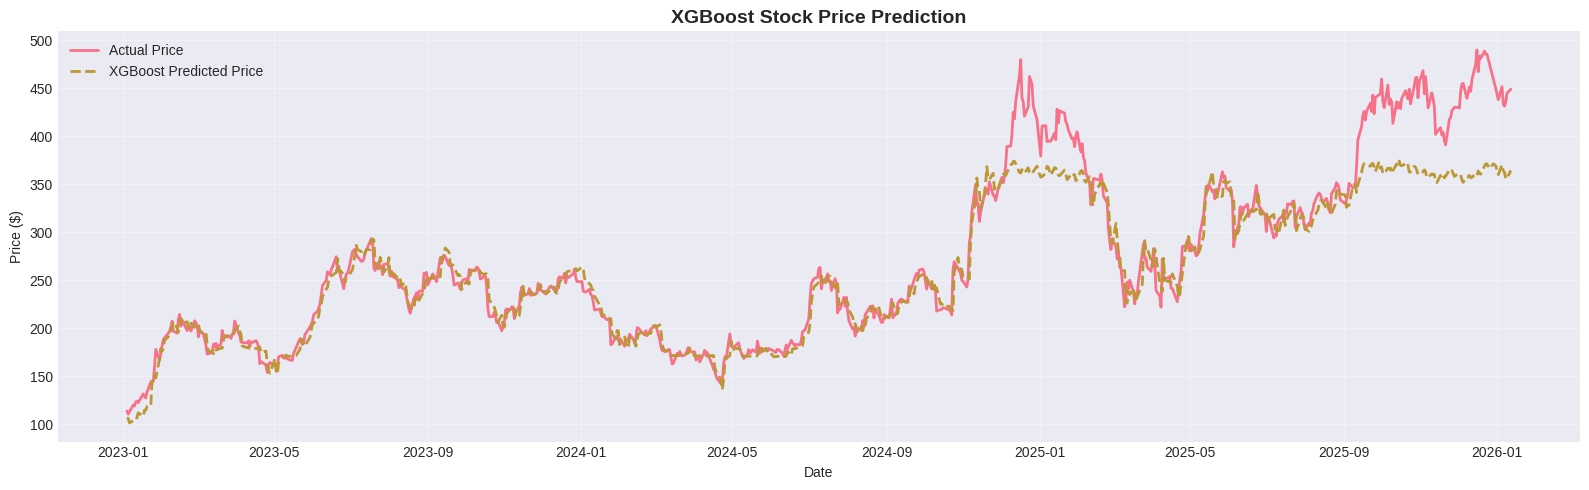

In [ ]:
# Plot ONLY XGBoost Predictions
plt.figure(figsize=(16, 5))

test_dates_xgb = df_features.index[train_size_xgb:]

plt.plot(test_dates_xgb, y_test_xgb.values,
         label='Actual Price', linewidth=2)

plt.plot(test_dates_xgb, predictions_xgb,
         label='XGBoost Predicted Price', linewidth=2, linestyle='--')

plt.title('XGBoost Stock Price Prediction', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


 MODEL COMPARISON AND FINAL RESULTS

In [ ]:
# Initialize if not already created
if 'results_comparison' not in globals():
    results_comparison = {}

# Add ALL models explicitly
results_comparison['ARIMA'] = {'RMSE': rmse_arima, 'MAE': mae_arima}
results_comparison['Prophet'] = {'RMSE': rmse_prophet, 'MAE': mae_prophet}
results_comparison['LSTM'] = {'RMSE': rmse_lstm, 'MAE': mae_lstm}
results_comparison['XGBoost'] = {'RMSE': rmse_xgb, 'MAE': mae_xgb}


In [ ]:
comparison_df = pd.DataFrame(results_comparison).T.sort_values('RMSE')

print("\n Performance Ranking (Best to Worst):")
display(comparison_df)



 Performance Ranking (Best to Worst):


,RMSE,MAE
LSTM,16.455786,12.054169
XGBoost,31.038441,17.726923
Prophet,139.722906,125.286936
ARIMA,169.553676,143.879071


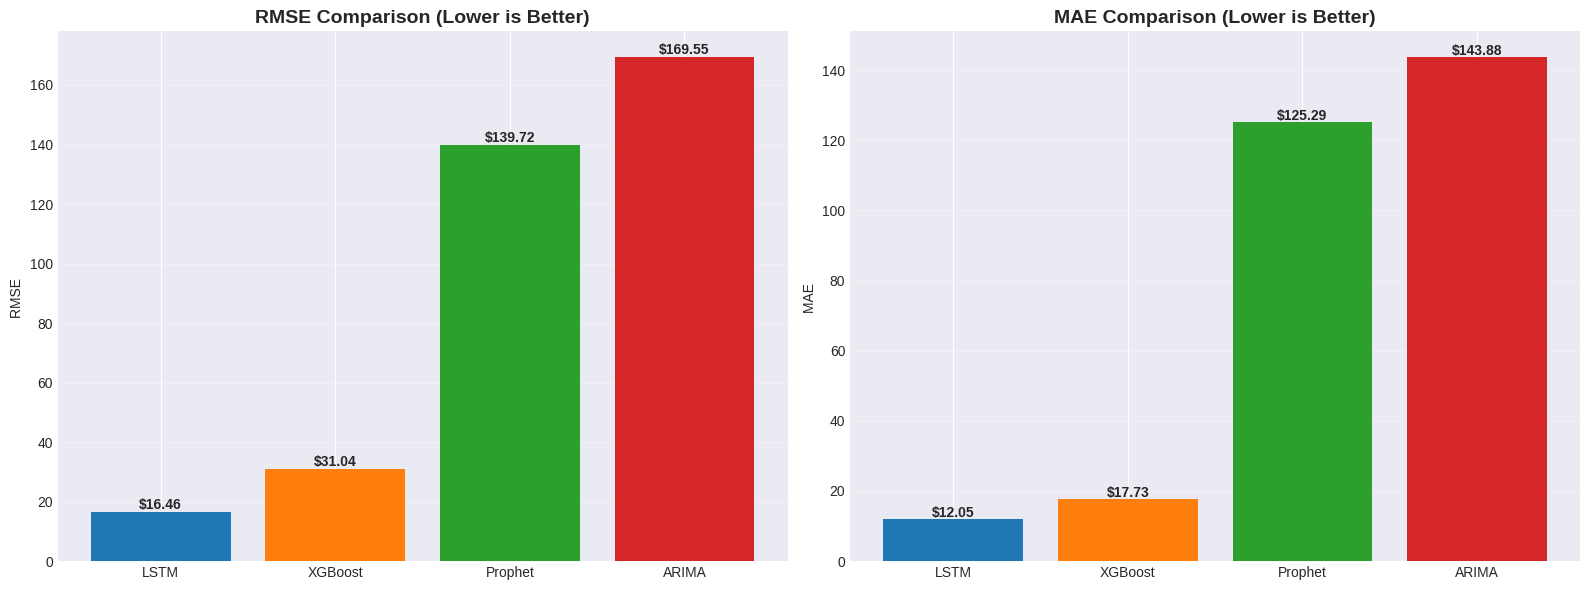


 BEST MODEL: LSTM
RMSE: 16.46
MAE: 12.05


In [ ]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
axes[0].bar(comparison_df.index, comparison_df['RMSE'], color=colors[:len(comparison_df)])
axes[0].set_title('RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMSE ')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['RMSE']):
    axes[0].text(i, v + 1, f'${v:.2f}', ha='center', fontweight='bold')

axes[1].bar(comparison_df.index, comparison_df['MAE'], color=colors[:len(comparison_df)])
axes[1].set_title('MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE ')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['MAE']):
    axes[1].text(i, v + 0.5, f'${v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

best_model = comparison_df.index[0]
print(f"\n BEST MODEL: {best_model}")
print(f"RMSE: {comparison_df.loc[best_model, 'RMSE']:.2f}")
print(f"MAE: {comparison_df.loc[best_model, 'MAE']:.2f}")


In [ ]:
# ARIMA next day prediction
arima_next_day = model_arima_fit.forecast(steps=1).iloc[0]

print("ARIMA Next Day Prediction:", round(arima_next_day, 2))

ARIMA Next Day Prediction: 127.01


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# Prophet next-day prediction
future_1_day = model_prophet.make_future_dataframe(periods=1)
forecast_1_day = model_prophet.predict(future_1_day)

prophet_next_day = forecast_1_day.iloc[-1]['yhat']


In [ ]:
# LSTM next day prediction
last_60_days = scaled_data[-look_back:]
X_next = last_60_days.reshape(1, look_back, 1)

lstm_next_scaled = model_lstm.predict(X_next)
lstm_next_day = scaler.inverse_transform(lstm_next_scaled)[0][0]

print("LSTM Next Day Prediction:", round(lstm_next_day, 2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
LSTM Next Day Prediction: 419.04


In [ ]:
# XGBoost next day prediction
last_features = df_features.iloc[-1][FEATURES].values.reshape(1, -1)

xgb_next_day = model_xgb.predict(last_features)[0]

print("XGBoost Next Day Prediction:", round(xgb_next_day, 2))


XGBoost Next Day Prediction: 364.27


In [ ]:
prediction_date = "2026-01-13"

print("\n Next Day Stock Price Prediction")
print("----------------------------------------")
print(f"Date     : {prediction_date}")
print("----------------------------------------")
print(f"ARIMA    : {arima_next_day:.2f}")
print(f"Prophet  : {prophet_next_day:.2f}")
print(f"LSTM     : {lstm_next_day:.2f}")
print(f"XGBoost  : {xgb_next_day:.2f}")



 Next Day Stock Price Prediction
----------------------------------------
Date     : 2026-01-13
----------------------------------------
ARIMA    : 127.01
Prophet  : 319.77
LSTM     : 419.04
XGBoost  : 364.27


In [ ]:
# ARIMA 1-month prediction
arima_30_days = model_arima_fit.forecast(steps=30)

arima_dates = pd.date_range(
    start=df_tesla.index[-1] + pd.Timedelta(days=1),
    periods=30
)

arima_forecast_df = pd.DataFrame({
    'Date': arima_dates,
    'ARIMA_Prediction': arima_30_days.values
})

arima_forecast_df.head()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Date,ARIMA_Prediction
0,2026-01-13 00:00:00-05:00,127.014171
1,2026-01-14 00:00:00-05:00,124.181554
2,2026-01-15 00:00:00-05:00,125.982959
3,2026-01-16 00:00:00-05:00,125.542751
4,2026-01-17 00:00:00-05:00,124.410502


In [ ]:
# Prophet 1-month prediction
future_30 = model_prophet.make_future_dataframe(periods=30)
forecast_30 = model_prophet.predict(future_30)

prophet_30_days = forecast_30[['ds', 'yhat']].tail(30)
prophet_30_days.columns = ['Date', 'Prophet_Prediction']

prophet_30_days.tail()


,Date,Prophet_Prediction
3081,2023-01-17,338.375939
3082,2023-01-18,338.139474
3083,2023-01-19,337.460418
3084,2023-01-20,337.033908
3085,2023-01-21,337.455793


In [ ]:
# LSTM 30-day prediction
last_sequence = scaled_data[-look_back:]
lstm_predictions = []

current_seq = last_sequence.copy()

for _ in range(30):
    pred = model_lstm.predict(current_seq.reshape(1, look_back, 1), verbose=0)
    lstm_predictions.append(pred[0, 0])
    current_seq = np.append(current_seq[1:], pred, axis=0)

lstm_30_days = scaler.inverse_transform(
    np.array(lstm_predictions).reshape(-1, 1)
).flatten()

lstm_dates = arima_dates

lstm_forecast_df = pd.DataFrame({
    'Date': lstm_dates,
    'LSTM_Prediction': lstm_30_days
})

lstm_forecast_df.head()


,Date,LSTM_Prediction
0,2026-01-13 00:00:00-05:00,419.035828
1,2026-01-14 00:00:00-05:00,417.106354
2,2026-01-15 00:00:00-05:00,411.087708
3,2026-01-16 00:00:00-05:00,403.287628
4,2026-01-17 00:00:00-05:00,395.008270


In [ ]:
# XGBoost 30-day prediction
xgb_predictions = []
last_row = df_features.iloc[-1].copy()

for i in range(30):
    # Ensure relevant date features are updated for the next day
    last_row['day'] = (last_row['day'] % 31) + 1 # Simple increment, might need more robust date handling
    if last_row['day'] == 1: # If day reset to 1, means month changed
        last_row['month'] = (last_row['month'] % 12) + 1
        if last_row['month'] == 1: # If month reset to 1, means year changed
            last_row['year'] += 1
    last_row['dayofweek'] = (last_row['dayofweek'] + 1) % 7 # Increment day of week
    # Recalculate quarter, dayofyear, weekofyear based on the new day, month, year
    # This simple increment might not be accurate for all date features, for a real app, use datetime objects.
    # For this demonstration, we'll keep it simple or assume these are not critical for short-term prediction

    X_input = last_row[FEATURES].values.reshape(1, -1)
    pred = model_xgb.predict(X_input)[0]
    xgb_predictions.append(pred)

    # Update lag features for the next prediction based on current prediction
    # We need to shift the existing lags down the line, and the new prediction becomes lag_1
    last_row['lag_30'] = last_row['lag_21'] # Value from 21 days ago becomes value from 30 days ago (for the next day)
    last_row['lag_21'] = last_row['lag_14']
    last_row['lag_14'] = last_row['lag_7']
    last_row['lag_7'] = last_row['lag_5']
    last_row['lag_5'] = last_row['lag_3']
    last_row['lag_3'] = last_row['lag_2']
    last_row['lag_2'] = last_row['lag_1']
    last_row['lag_1'] = pred # The new prediction becomes the most recent lag
    #lag-excat past value
    #rolling mean-avaerge of past valus
    #rolling std-past volatility
    # Rolling features are harder to update iteratively without recalculating over a full window.
    # For simplicity, we are not updating rolling_mean/std in this forward-looking loop.
    # For production, these would need to be re-computed or handled with more complex logic.

xgb_forecast_df = pd.DataFrame({
    'Date': arima_dates,
    'XGBoost_Prediction': xgb_predictions
})

xgb_forecast_df.head()

,Date,XGBoost_Prediction
0,2026-01-13 00:00:00-05:00,363.327606
1,2026-01-14 00:00:00-05:00,361.757385
2,2026-01-15 00:00:00-05:00,353.085175
3,2026-01-16 00:00:00-05:00,352.867493
4,2026-01-17 00:00:00-05:00,351.701263


In [ ]:
monthly_forecast = pd.DataFrame({
    'Date': arima_dates,
    'ARIMA': arima_30_days.values,
    'Prophet': prophet_30_days['Prophet_Prediction'].values,
    'LSTM': lstm_30_days,
    'XGBoost': xgb_predictions
})

monthly_forecast.head()

,Date,ARIMA,Prophet,LSTM,XGBoost
0,2026-01-13 00:00:00-05:00,127.014171,319.772334,419.035828,363.327606
1,2026-01-14 00:00:00-05:00,124.181554,321.767290,417.106354,361.757385
2,2026-01-15 00:00:00-05:00,125.982959,323.044593,411.087708,353.085175
3,2026-01-16 00:00:00-05:00,125.542751,324.202718,403.287628,352.867493
4,2026-01-17 00:00:00-05:00,124.410502,325.257449,395.008270,351.701263


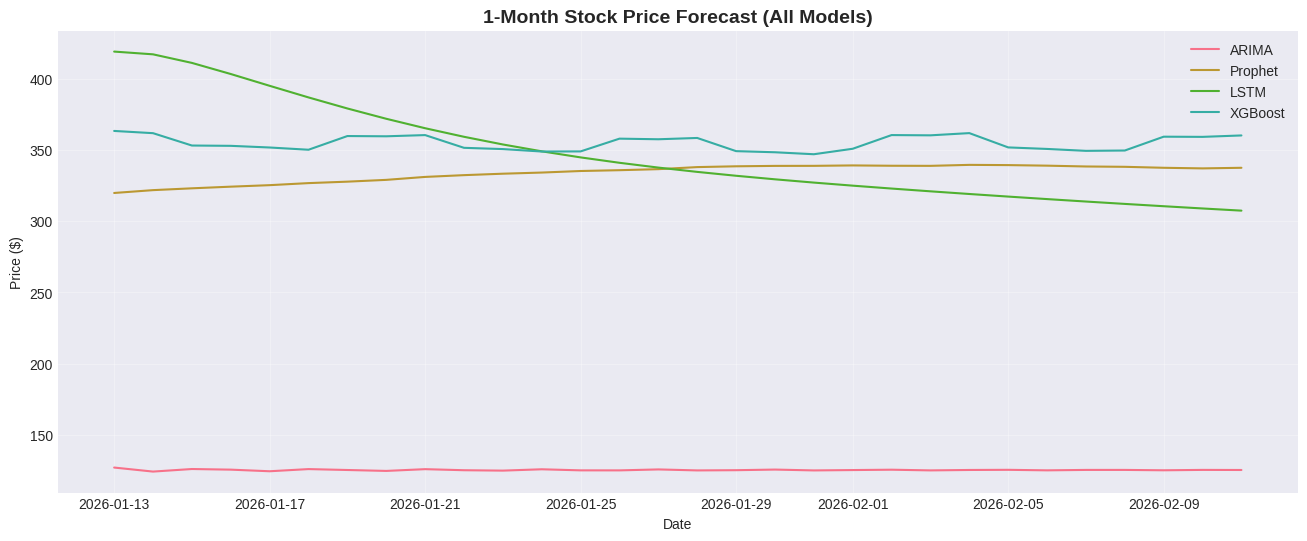

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(monthly_forecast['Date'], monthly_forecast['ARIMA'], label='ARIMA')
plt.plot(monthly_forecast['Date'], monthly_forecast['Prophet'], label='Prophet')
plt.plot(monthly_forecast['Date'], monthly_forecast['LSTM'], label='LSTM')
plt.plot(monthly_forecast['Date'], monthly_forecast['XGBoost'], label='XGBoost')

plt.title('1-Month Stock Price Forecast (All Models)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
